In [ ]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import pysimul
from common import *
from math import *

In [ ]:
simul = pysimul.PySimul()
simul['T'] = T = 1
simul['gamma'] = gamma = 1
D = T / gamma
part_m = 0
#simul['part_m'] = part_m = 0.1
reset_type = 'poisson'
simul['reset_rate'] = α = 5
#simul['reset_period'] = rT = 0.002
simul['x0sigma'] = σ = 0.1
path = "data-poisson-x0var/"

In [ ]:
if reset_type == 'none':
    th_fpt_distrib = None # TODO
    th_tau = None
    th_c = None
elif reset_type == 'poisson':
    th_fpt_distrib = None
    th_tau = fpt_poisson_tau
    th_c = lambda L: fpt_poisson_c(α, D, L)
elif reset_type == 'per':
    th_fpt_distrib = lambda t, b, c: fpt_periodic_disrib(t, rT, b, c)
    th_tau = fpt_periodic_tau
    th_c = lambda L: fpt_periodic_c(rT, D, L)
tau_th_cache = None

In [ ]:
simul.start()

In [ ]:
simul.end()

In [ ]:
simul['n_trajectories']

In [ ]:
simul['pause'] = 1

### MFPT saving

In [ ]:
i_beg = 80

In [ ]:
Res = pd.DataFrame()
simul.explicit_lock()
first_times_xtarg = simul['first_times_xtarg']
for i in range(len(first_times_xtarg)):
    first_times = simul['first_times-'+str(i)]
    path2 = path+str(i+i_beg)
    np.savetxt(path2+"-ft.csv", first_times, fmt='%.2e')
    x_targ = first_times_xtarg[i]
    d = {
        'D': D,
        'T': T,
        'gamma': gamma,
        'part_m': part_m,
        'x0sigma': σ,
        'L': x_targ,
        'L_err': simul['xtarg_tol'],
        'b': x_targ/σ,
        'c': th_c(x_targ),
        'c_err': th_c(simul['xtarg_tol']),
        'mfpt': np.mean(first_times),
        'fpt_stdev': np.std(first_times),
        'n_traj': len(first_times),
        'Delta_t': simul['Delta_t']
    }
    if reset_type == 'none':
        pass
    elif reset_type == 'poisson':
        d['reset_rate'] = α
    elif reset_type == 'per':
        d['reset_period'] = rT
    df = pd.DataFrame(list(d.items())).set_index(0)
    df.to_csv(path2+"-params.csv", header=False, quoting=csv.QUOTE_NONE, sep=',')
    Res = Res.append(df.T, ignore_index=True, sort=False)
simul.explicit_unlock()

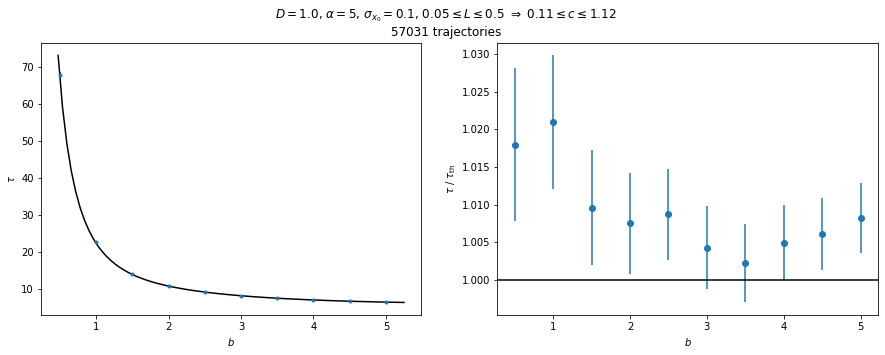

In [45]:
Res['tau'] = 4*Res['D']*Res['mfpt']/Res['L']**2
Res['tau_err'] = 4*Res['D']*(Res['fpt_stdev']/np.sqrt(Res['n_traj']))/Res['L']**2

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
L = np.linspace(np.min(Res['L'])*0.95, np.max(Res['L'])*1.05, 80)
b = L/σ
if tau_th_cache is not None:
    ax1.plot(b, tau_th_cache, color='black')
ax1.errorbar(Res['b'], Res['tau'], yerr=Res['tau_err'], fmt='.')
ax1.set_ylabel(r"$\tau$")
ax1.set_xlabel(r"$b$")
ax2.errorbar(Res['b'], Res['tau']/th_tau(Res['b'],Res['c']), yerr=Res['tau_err']/th_tau(Res['b'],Res['c']), fmt='o')
ax2.axhline(y=1, color='black')
ax2.set_ylabel(r"$\tau\ /\ \tau_\operatorname{th}$")
ax2.set_xlabel(r"$b$")
if reset_type == 'poisson':
    fig.suptitle((r"$D={}$, $\alpha={}$, $\sigma_{{x_0}}={}$, ${} \leq L \leq {} \ \Rightarrow \  {:.2f} \leq c \leq {:.2f}$"+"\n{} trajectories").format(D, α, σ, np.min(Res['L']), np.max(Res['L']), np.min(Res['c']), np.max(Res['c']), int(Res['n_traj'].iloc[0])))
elif reset_type == 'per':
    fig.suptitle((r"$D={}$, $T_\operatorname{{res}}={}$, $\sigma_{{x_0}}={}$, ${} \leq L \leq {} \ \Rightarrow \  {:.2f} \leq c \leq {:.2f}$"+"\n{} trajectories").format(D, rT, σ, np.min(Res['L']), np.max(Res['L']), np.min(Res['c']), np.max(Res['c']), int(Res['n_traj'].iloc[0])))
plt.savefig(path+str(i_beg)+"-summary.pdf", bbox_inches='tight')
plt.show()
if tau_th_cache is None:
    tau_th_cache = th_tau(b, c=th_c(L))

---
### FPT distrubution for one $L$

In [46]:
i = 6
simul.explicit_lock()
first_times = simul['first_times-'+str(i)]
n_traj = len(first_times)
if simul['n_trajectories'] != n_traj:
    print("Number of trajectories don't match up !")
L = simul['first_times_xtarg'][i]
simul.explicit_unlock()
b = L/σ
c = th_c(L)
mfpt_th = L**2/(4*D)*th_tau(b,c)
mfpt = np.mean(first_times)

def fpt_distrib_title ():
    plt.xlabel("first passage time")
    if reset_type == 'poisson':
        plt.title(r"FPT distribution for $b={:.2f}$, $c={:.2f}$ ($D={}$, $\alpha={}$, $\sigma_{{x_0}}={}$, $L={}$)".format(b, c, D, α, σ, L))
    elif reset_type == 'per':
        plt.title(r"FPT distribution for $b={:.2f}$, $c={:.2f}$ ($D={}$, $T_\operatorname{{res}}={}$, $\sigma_{{x_0}}={}$, $L={}$)".format(b, c, D, rT, σ, L))
    plt.legend()

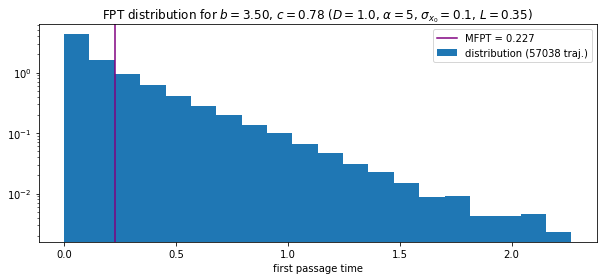

In [47]:
plt.figure(figsize=(10,4))
fpt_max = 10*mfpt_th
plt.hist(first_times, bins=20, range=(0,fpt_max), weights=20/fpt_max*np.ones(n_traj)/n_traj, label="distribution ({} traj.)".format(n_traj))
plt.axvline(x=mfpt, color='purple', label="MFPT = {:.3f}".format(mfpt))
plt.yscale('log')
fpt_distrib_title()
None

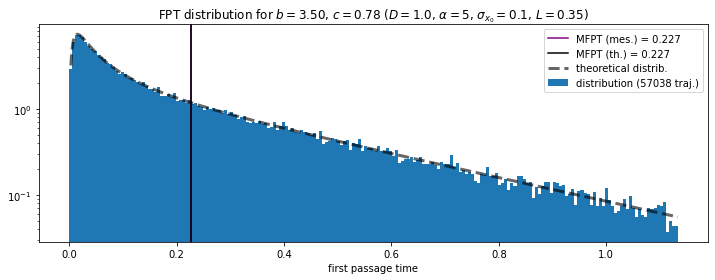

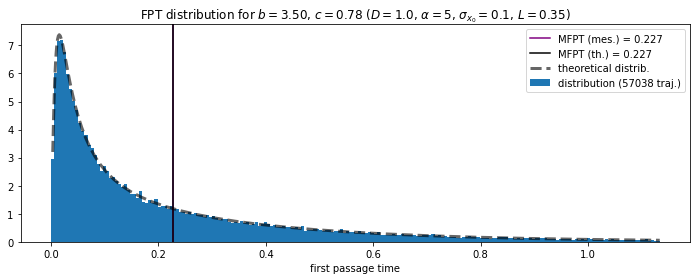

In [48]:
if reset_type == 'per':
    fpt_max = 0.999*max(3, ceil(2*mfpt_th/rT))*rT
    t_th = np.linspace(0, fpt_max, 400)+3e-4
    d_th = -( fpt_periodic_survival(t_th+1e-4, rT, b, c) - fpt_periodic_survival(t_th-1e-4, rT, b, c) ) / 2e-4
elif reset_type == 'poisson':
    fpt_max = 5*mfpt_th
    t_th = np.logspace(log(mfpt_th/20/b), log(fpt_max), 50, base=np.e)
    d_th = fpt_poisson_distrib(L, t_th, α, D, σ)
else:
    fpt_max = 5*mfpt_th
    t_th = None

def do_fpt_distrib (log=True):
    global fpt_max, t_th, d_th
    plt.figure(figsize=(12,4))
    _,bins,_ = plt.hist(first_times, bins=200, range=(0,fpt_max), weights=200/fpt_max*np.ones(n_traj)/n_traj, label="distribution ({} traj.)".format(n_traj))
    plt.axvline(x=mfpt, color='purple', label="MFPT (mes.) = {:.3f}".format(mfpt))
    plt.axvline(x=mfpt_th, color='black', label="MFPT (th.) = {:.3f}".format(mfpt_th))
    if t_th is not None:
        plt.plot(t_th, d_th, label=r"theoretical distrib.", color='black', linestyle='dashed', lw=3, alpha=0.6)
    if log:
        plt.yscale('log')
    fpt_distrib_title()
    plt.savefig(path+str(i+i_beg)+"-fpt-"+("log" if log else "lin")+".pdf", bbox_inches='tight')

do_fpt_distrib(True)
do_fpt_distrib(False)